# RECORD TRAINING TIME!!!!


In [30]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
from project.utils import compute_statistics
from project.evaluation import isa_vit_metric, count_fptpfn, Tracker

In [31]:
vit_tk = Tracker()

### Monitoring and CUDA Setup


In [32]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Dec_09_2024_082732'

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [34]:
vit_tk.date = rn
vit_tk.logfile = f'rpn_vit_{dte}.log'
vit_tk.device = device

### Config for RPN and ViT Fitter


In [35]:
from project.model import ISAVIT, Feeder

In [36]:
image_size = 300
patch_size = 32

### Dataset Loading


In [37]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [38]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000,39


In [39]:
vit_tk.only_cmb_slices = True

In [40]:
def make_feedset(
        data,
        target_shape=(300, 300),
        rpn_mode=True,
        logger=None
    ):
    s = f'Creating feedset\n'
    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'
    global_min, global_max = compute_statistics(paths)
    
    feedset_transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )
    feedset = VALDODataset(
    cases=data.stripped,
    masks=data.masks,
    target=data.target,
    transform=feedset_transform
    )
    print(s)
    return feedset

In [41]:
feedset = make_feedset(
    data=data,
    rpn_mode=True,
    target_shape=(300, 300)
)

Creating feedset
Total Unique MRI Samples in data_train: 50
GLOBAL MIN & MAX (0.0, 87519.8515625)



### Preprocessing and Train-Test Split Function


In [42]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                ):
    
    if cohort == 1:
        vit_tk.cohort1 = True
    if cohort == 2:
        vit_tk.cohort2 = True
    if cohort == 3:
        vit_tk.cohort3 = True

    vit_tk.test_size = test_size
    vit_tk.target_shape = target_shape
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

In [43]:
from project import Fitter
from project.preprocessing import get_transform

In [44]:
resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

In [45]:
import torch

In [46]:
feeder = Feeder(resize)

In [47]:
import numpy as np

### ViT Fitter


In [48]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader)
            val_loss, val_metric = self.validation(val_loader)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        TP = 0
        FP = 0
        FN = 0
        counter = 0
        total_sample = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(self.device)
                masks = masks.float().to(self.device)

                regions = feedset.locate_case_by_mri(case)
                bboxes = regions[1].view(regions[1].shape[0], -1)
                bbox = bboxes[target].int().tolist()
                
                x = feeder(slices, bbox, 32)
                t = feeder(masks, bbox, 32)

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)                
                y = self.model(x, target)
                tp, fp, fn = count_fptpfn(y, t[target])

                TP += tp
                FP += fp
                FN += fn
                total_sample += 1

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        dice_score, precision_score, recall_score, f1_score, fp_avg = isa_vit_metric(TP, FP, FN, total_sample)
        evaluation_metric['dice_score'].append(dice_score)
        evaluation_metric['precision_score'].append(precision_score)
        evaluation_metric['recall_score'].append(recall_score)
        evaluation_metric['f1_score'].append(f1_score)
        evaluation_metric['fpr'].append(fp_avg)

        self.log(f'\nTraining Evaluation Metric:')
        self.log(f'Dice: {dice_score}\nPrecision: {precision_score}\nRecall: {recall_score}\nF1: {f1_score}\nFPavg: {fp_avg}')
        return loss_history, evaluation_metric
    
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        TP = 0
        FP = 0
        FN = 0
        total_sample = 0
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    regions = feedset.locate_case_by_mri(case)
                    bboxes = regions[1].view(regions[1].shape[0], -1)
                    bbox = bboxes[target].int().tolist()
                
                    x = feeder(slices, bbox, 32)
                    t = feeder(masks, bbox, 32)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    tp, fp, fn = count_fptpfn(y, t[target])

                    TP += tp
                    FP += fp
                    FN += fn
                    total_sample += 1
                    Y.append(y)
                    T.append(t[target])
                    
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        
        dice_score, precision_score, recall_score, f1_score, fp_avg = isa_vit_metric(TP, FP, FN, total_sample)
        evaluation_metric['dice_score'].append(dice_score)
        evaluation_metric['precision_score'].append(precision_score)
        evaluation_metric['recall_score'].append(recall_score)
        evaluation_metric['f1_score'].append(f1_score)
        evaluation_metric['fpr'].append(fp_avg)

        self.log(f'\nValidations Evaluation Metric:')
        self.log(f'Dice: {dice_score}\nPrecision: {precision_score}\nRecall: {recall_score}\nF1: {f1_score}\nFPavg: {fp_avg}')
        return loss_history, evaluation_metric

### Train-Test Split


In [49]:
vit_t1, vit_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False
)

vit_t3, vit_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [50]:
from torch.utils.data import ConcatDataset

vit_train_set = ConcatDataset([vit_t1, vit_t3])
vit_test_set = ConcatDataset([vit_v1, vit_v3])

print(f'ViT Train Set Size: {vit_train_set}')
print(f'ViT Test Set Size: {vit_test_set}')

ViT Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000013A50F4DBD0>
ViT Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000013A7BC5DF50>


In [51]:
batchs = 20
vit_tk.batch_size = batchs

vit_test_dataloader = DataLoader(
    vit_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

In [52]:
# class FocalTverskyLoss(nn.Module):
#     def __init__(self, alpha=0.7, beta=0.3, gamma=1.33, smooth=1e-6):
#         super(FocalTverskyLoss, self).__init__()
#         self.alpha = alpha
#         self.beta = beta
#         self.gamma = gamma
#         self.smooth = smooth

#     def forward(self, inputs, targets):
#         inputs = torch.sigmoid(inputs) 
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         true_pos = (inputs * targets).sum()
#         false_neg = ((1 - inputs) * targets).sum()
#         false_pos = (inputs * (1 - targets)).sum()

#         tversky_index = (true_pos + self.smooth) / (
#             true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth)
#         focal_tversky = (1 - tversky_index) ** self.gamma
#         return focal_tversky


In [53]:
class CombinedFocalTverskyBCE(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.33, bce_weight=0.5, smooth=1e-6):
        super(CombinedFocalTverskyBCE, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.bce_weight = bce_weight
        self.smooth = smooth
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        inputs_sigmoid = torch.sigmoid(inputs)
        
        true_pos = (inputs_sigmoid * targets).sum()
        false_neg = ((1 - inputs_sigmoid) * targets).sum()
        false_pos = (inputs_sigmoid * (1 - targets)).sum()
        
        tversky_index = (true_pos + self.smooth) / (
            true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth
        )
        focal_tversky_loss = (1 - tversky_index) ** self.gamma
        
        bce_loss = self.bce_loss(inputs, targets)
        
        combined_loss = focal_tversky_loss + self.bce_weight * bce_loss
        return combined_loss


In [54]:
vit_config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600,
        global_context=False,
        patchpatch_size=16,
        n_layers=12
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 50,
    'loss': CombinedFocalTverskyBCE(alpha=0.5, beta=0.5, gamma=1.33, bce_weight=0.5),
    'lr': 0.0001
}

vit_tk.model = 'ViT'
vit_tk.model_hyperparams = vit_config['model'].config
vit_tk.optimizer = f"{vit_config['optimizer']}"
vit_tk.epochs = vit_config['epochs']
vit_tk.loss = f"{vit_config['loss']}"
vit_tk.lr = vit_config['lr']

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### K-Fold Cross Validation


In [55]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [57]:
vit_test_dice = []
vit_test_precision = []
vit_test_recall = []
vit_test_f1 = []
vit_test_fpr = []

In [58]:
rpn_fold_metrics = []
vit_fold_metrics = []


fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(vit_train_set)):
    print(f'Fold {i + 1}/{5}')

    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)

    # ViT
    
    vit_config['model'] = ISAVIT(**vit_tk.model_hyperparams).to(device)
    
    vit_fitter = ViTFitter(vit_config, logger=logger)
    
    train_subset = Subset(vit_train_set, train_index)
    val_subset = Subset(vit_train_set, val_index)

    vit_tk.batch_size = 20
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    vit_thist, vit_vhist, vit_tmhist, vit_vmhist = vit_fitter.fit(train_subset_dl, val_subset_dl)
    
    vit_fold_metrics.append({
        'fold': i + 1,
        'training_history': vit_thist,
        'validation_history': vit_vhist,
        'training_metrics': vit_tmhist,
        'validation_metrics': vit_vmhist
    })
    
    vit_h, vit_mh = vit_fitter.validation(vit_test_dataloader)
    vit_valmets = pd.DataFrame(vit_mh)
    vit_mets = vit_valmets.mean()
    
    vit_test_dice.append(vit_mets.dice_score)
    vit_test_precision.append(vit_mets.precision_score)
    vit_test_recall.append(vit_mets.recall_score)
    vit_test_f1.append(vit_mets.f1_score)
    vit_test_fpr.append(vit_mets.fpr)
    
    torch.save(vit_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/vit_fold{i+1}.pt')

    

Fold 1/5


d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.3620868921279907

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.3143386840820312

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	1.2858728170394897

INFO:kess:
Training Evaluation Metric:
INFO:kess:Dice: 0.03256043413912185
Precision: 0.016549648946840523
Recall: 1.0
F1: 0.03256043413912185
FPavg: 67.62068965517241
INFO:kess:
Validations Evaluation Metric:
INFO:kess:Dice: 0.07692307692307693
Precision: 0.040229885057471264

Fold 2/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.3557523488998413

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.312321424484253

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	1.286252737045288

INFO:kess:
Training Evaluation Metric:
INFO:kess:Dice: 0.032913345332990486
Precision: 0.01673202614379085
Recall: 1.0
F1: 0.032913345332990486
FPavg: 64.84482758620689
INFO:kess:
Validations Evaluation Metric:
INFO:kess:Dice: 0.062157221206581355
Precision: 0.03213610586011342
Recall: 0.9444444444444444
F1: 0.06215722120658136
FPavg: 34.13333333333333
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.2673654556274414

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.2485990524291992

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	1.234

Fold 3/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.3641268014907837

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.3171931505203247

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	1.2894264459609985

INFO:kess:
Training Evaluation Metric:
INFO:kess:Dice: 0.03455497382198953
Precision: 0.017581246670218435
Recall: 1.0
F1: 0.03455497382198953
FPavg: 63.58620689655172
INFO:kess:
Validations Evaluation Metric:
INFO:kess:Dice: 0.053475935828877004
Precision: 0.027522935779816515
Recall: 0.9375
F1: 0.053475935828877004
FPavg: 35.333333333333336
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.2675280570983887

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.2493999004364014

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	1.23557507991

Fold 4/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.3520234823226929

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.3082278966903687

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	1.283529281616211

INFO:kess:
Training Evaluation Metric:
INFO:kess:Dice: 0.03657880580957504
Precision: 0.01863013698630137
Recall: 1.0
F1: 0.03657880580957504
FPavg: 60.71186440677966
INFO:kess:
Validations Evaluation Metric:
INFO:kess:Dice: 0.07492795389048991
Precision: 0.03903903903903904
Recall: 0.9285714285714286
F1: 0.07492795389048991
FPavg: 22.857142857142858
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.2641311883926392

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.2461235523223877

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	1.2328

Fold 5/5


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.3563439846038818

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.3151936531066895

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	1.289902925491333

INFO:kess:
Training Evaluation Metric:
INFO:kess:Dice: 0.034325556449450255
Precision: 0.017462482946794
Recall: 1.0
F1: 0.034325556449450255
FPavg: 61.03389830508475
INFO:kess:
Validations Evaluation Metric:
INFO:kess:Dice: 0.07860262008733625
Precision: 0.04090909090909091
Recall: 1.0
F1: 0.07860262008733623
FPavg: 30.142857142857142
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.2711946964263916

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	1.2535505294799805

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	1.239011526107788

INFO:kess:
Training Evaluation Metric:
INFO:kess:Di

In [59]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [61]:
def plot_metric_history(fold_metrics, metric, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
            
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label=f'Training {metric}')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label=f'Validation {metric}')
    
    plt.title(f'{title} - Training and Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
        
    plt.tight_layout()  
    plt.show()

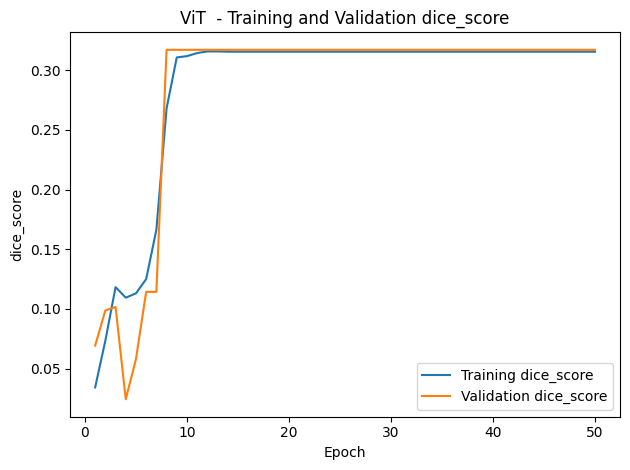

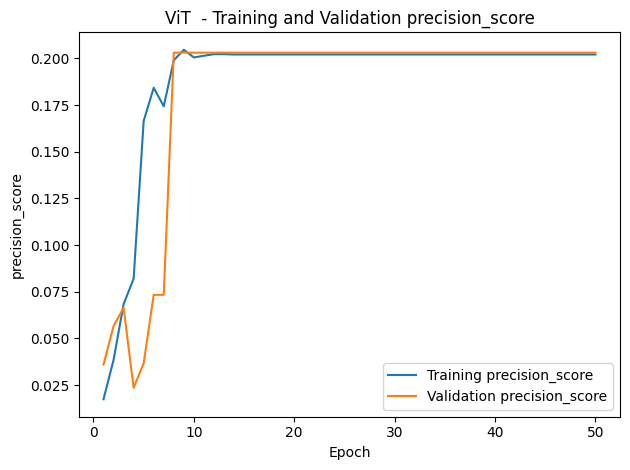

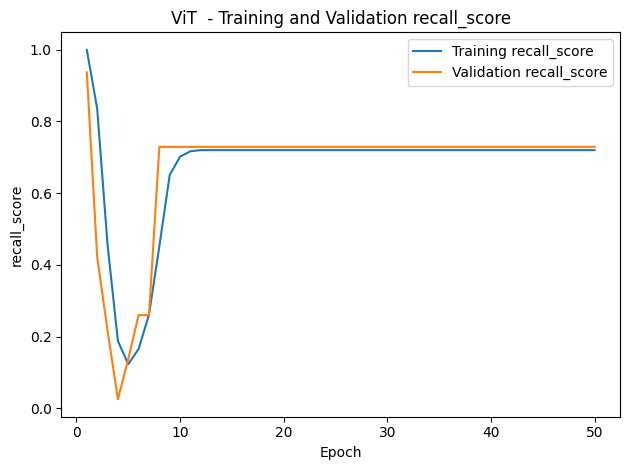

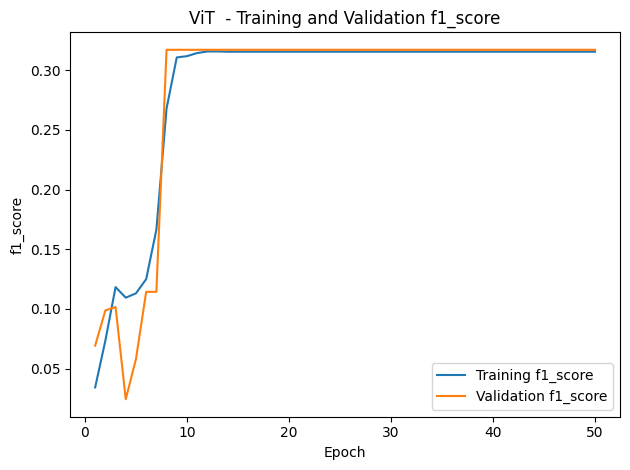

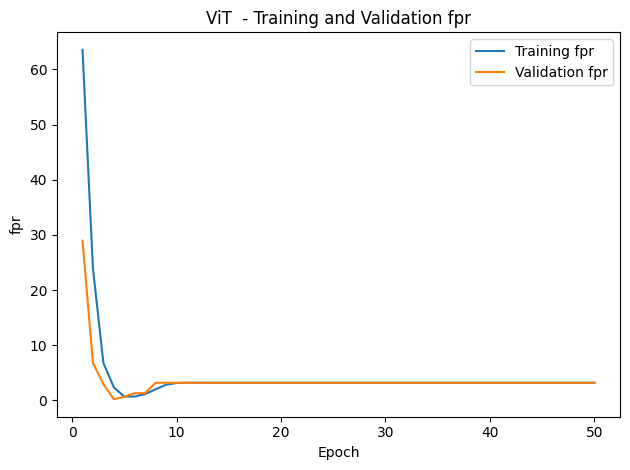

In [62]:
vit_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in vit_metrics:
    plot_metric_history(vit_fold_metrics, metric, 'ViT ')

### Loss History Visualization


In [63]:
def plot_loss_history(fold_metrics, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
        
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label='Training history')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label='Validation history')
        
    plt.title(f'{title} - Training and Validation history')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    
    plt.tight_layout()  
    plt.show()

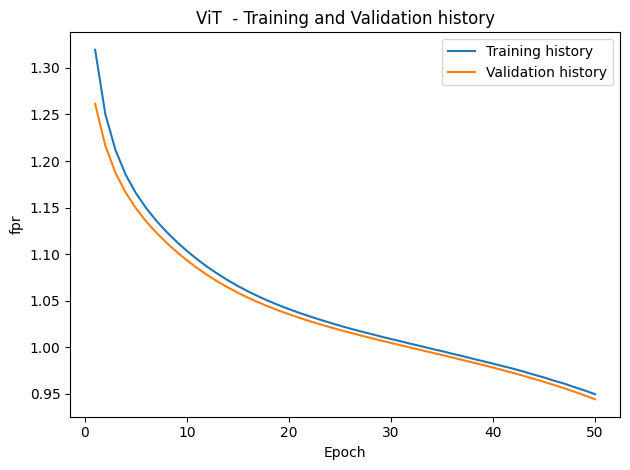

In [64]:
plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### ViT


In [65]:
df_vit_metrics = pd.DataFrame(columns=['fold', 'dice', 'precision', 'recall', 'f1', 'fpr'])
df_vit_metrics

,fold,dice,precision,recall,f1,fpr


In [66]:
df_vit_metrics['fold'] = [1, 2, 3, 4, 5]
df_vit_metrics['dice'] = vit_test_dice
df_vit_metrics['precision'] = vit_test_precision
df_vit_metrics['recall'] = vit_test_recall
df_vit_metrics['f1'] = vit_test_f1
df_vit_metrics['fpr'] = vit_test_fpr

In [67]:
vit_tk.dice = df_vit_metrics.dice
vit_tk.precision = df_vit_metrics.precision
vit_tk.recall = df_vit_metrics.recall
vit_tk.f1 = df_vit_metrics.f1
vit_tk.fpr = df_vit_metrics.fpr

In [68]:
df_vit_metrics

,fold,dice,precision,recall,f1,fpr
0,1,0.333333,0.223684,0.653846,0.333333,3.105263
1,2,0.333333,0.223684,0.653846,0.333333,3.105263
2,3,0.333333,0.223684,0.653846,0.333333,3.105263
3,4,0.333333,0.223684,0.653846,0.333333,3.105263
4,5,0.333333,0.223684,0.653846,0.333333,3.105263


In [69]:
# vit_iou_score = np.array(vit_test_iou).mean()
vit_dice_score = np.array(vit_test_dice).mean()
vit_precision_score = np.array(vit_test_precision).mean()
vit_recall_score = np.array(vit_test_recall).mean()
vit_f1_score = np.array(vit_test_f1).mean()
vit_fpr_score = np.array(vit_test_fpr).mean()

print('ViT Test Set Performance Metrics')
print(f'Average Dice Score: {vit_dice_score} ')
print(f'Average Precision: {vit_precision_score} ')
print(f'Average Recall: {vit_recall_score} ')
print(f'Average F1 Score: {vit_f1_score} ')
print(f'Average FPR: {vit_fpr_score} ')

ViT Test Set Performance Metrics
Average Dice Score: 0.3333333333333333 
Average Precision: 0.2236842105263158 
Average Recall: 0.6538461538461539 
Average F1 Score: 0.3333333333333333 
Average FPR: 3.1052631578947367 


In [70]:
df_vit_metrics.to_csv(f'{fold_dir}/vit_metrics.csv')

In [71]:
df_vit_metrics.to_csv(f'./statistical-treatment/perfect-bbox-vanilla-vit.csv')

### Sample


#### ViT


In [72]:
import matplotlib.patches as patches

C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_24396\1187895178.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, a = plt.subplots(1, 2, figsize=(10, 4))


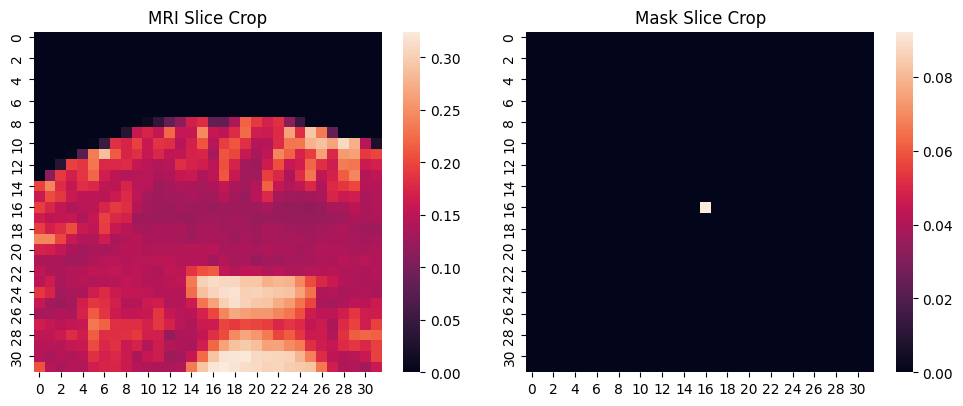

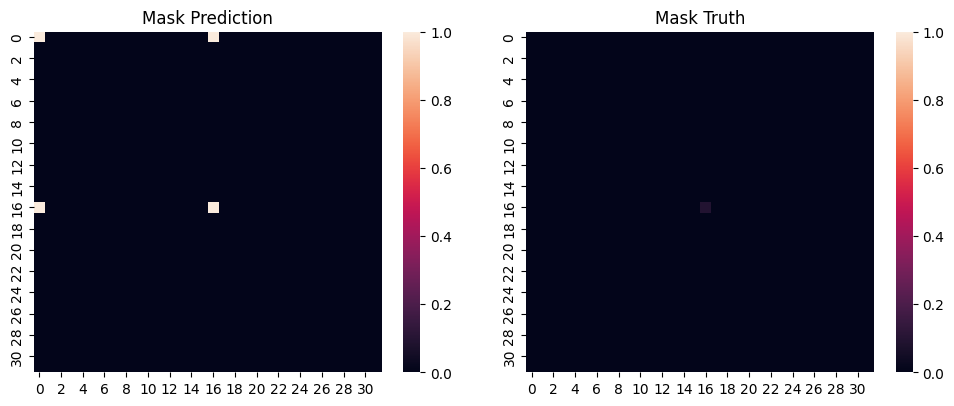

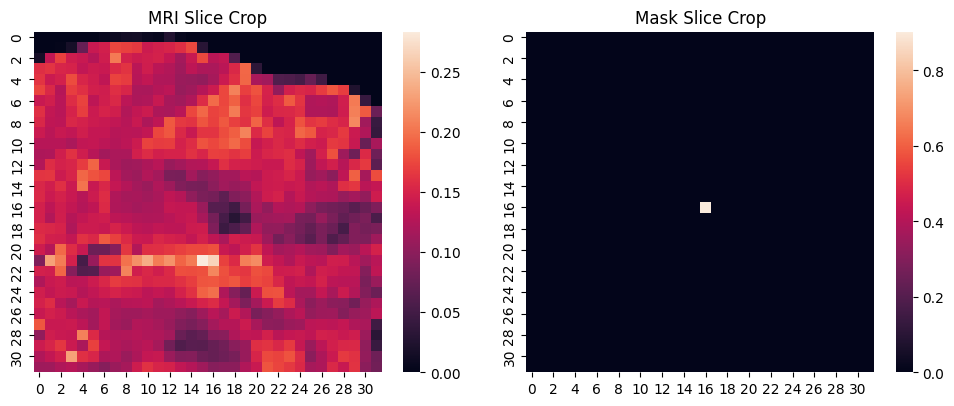

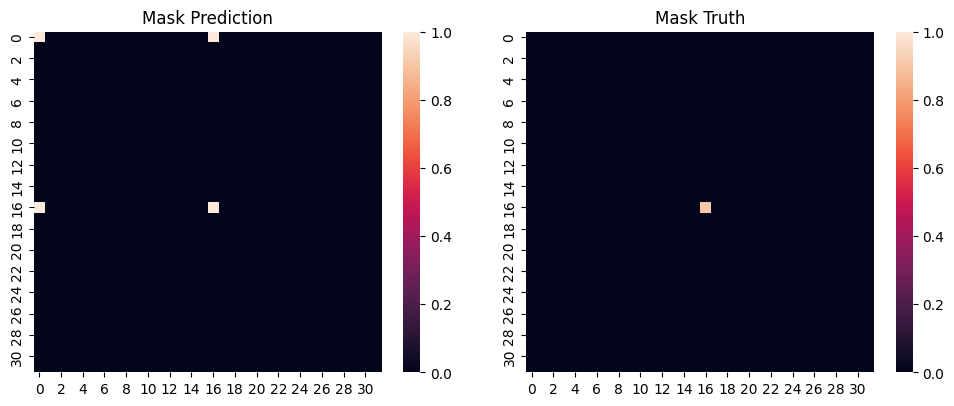

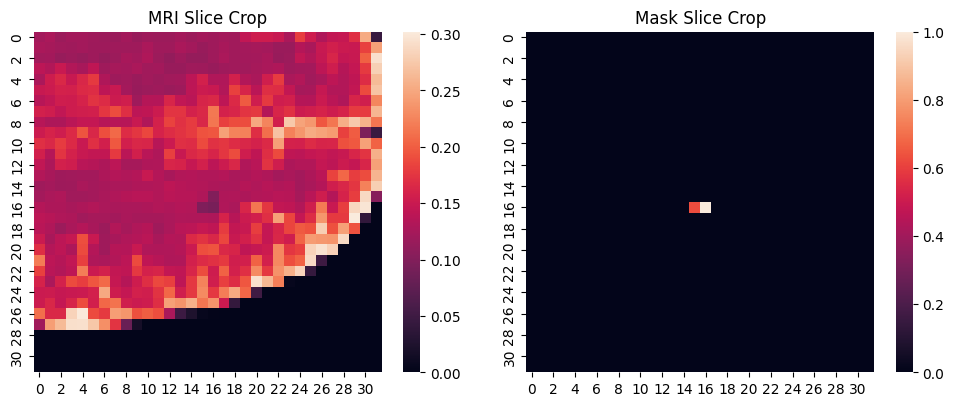

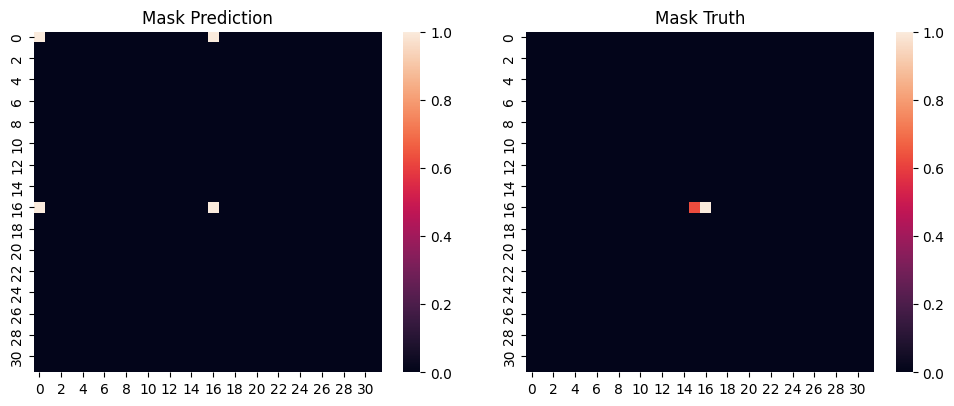

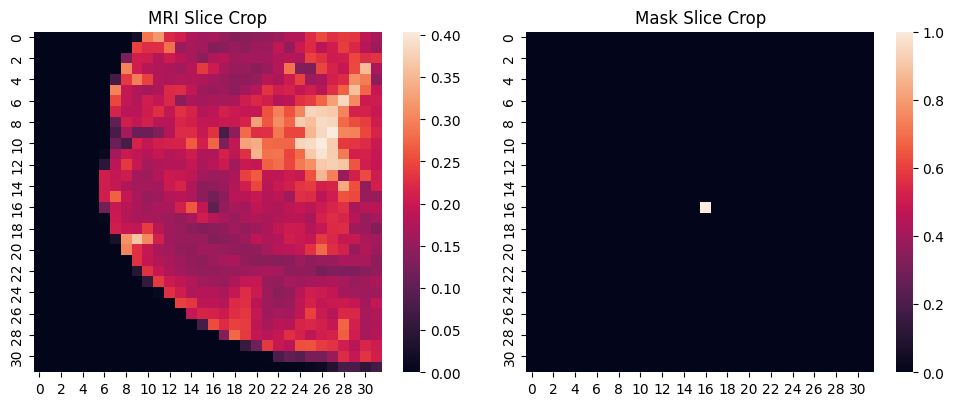

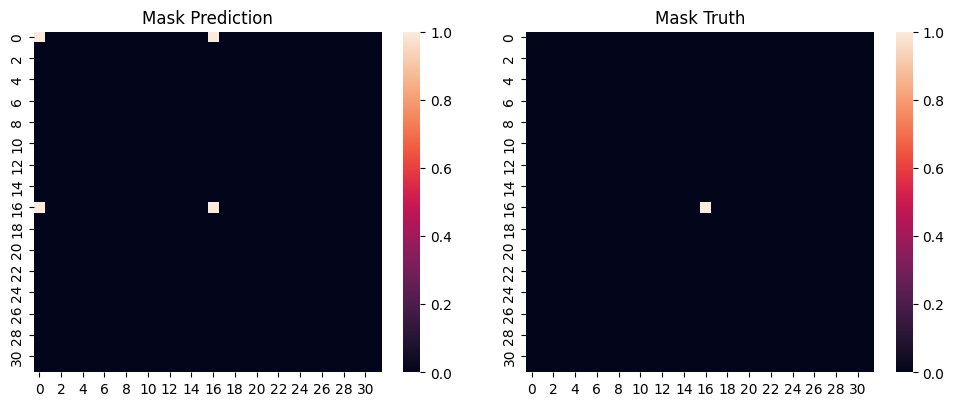

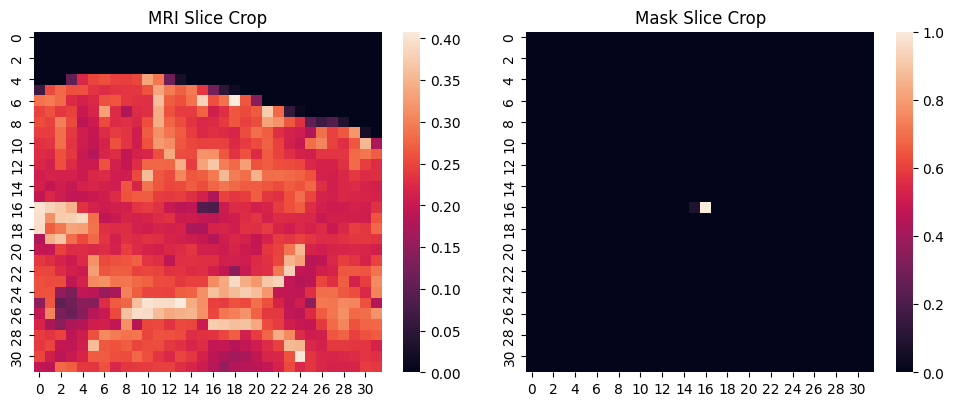

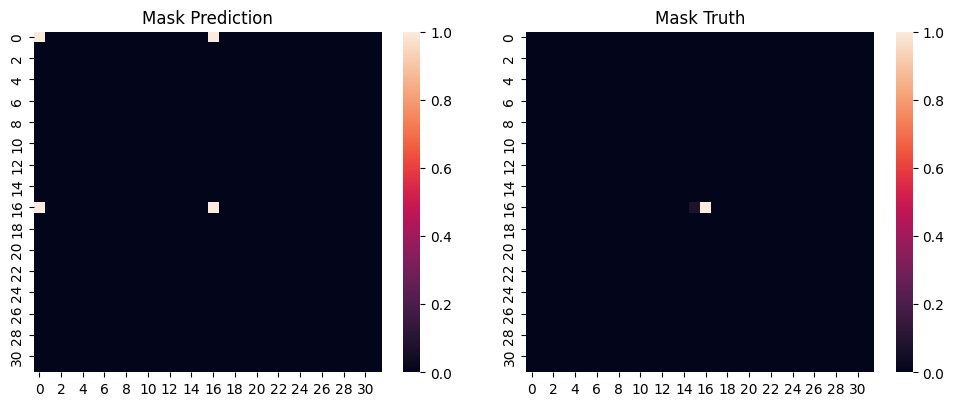

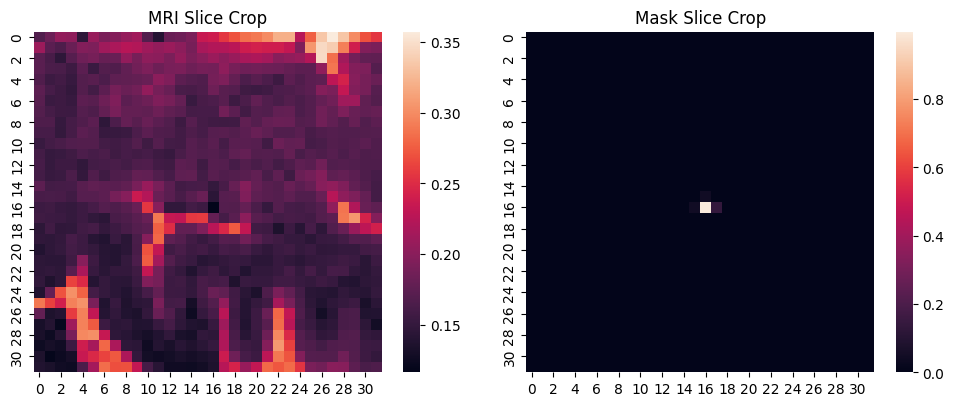

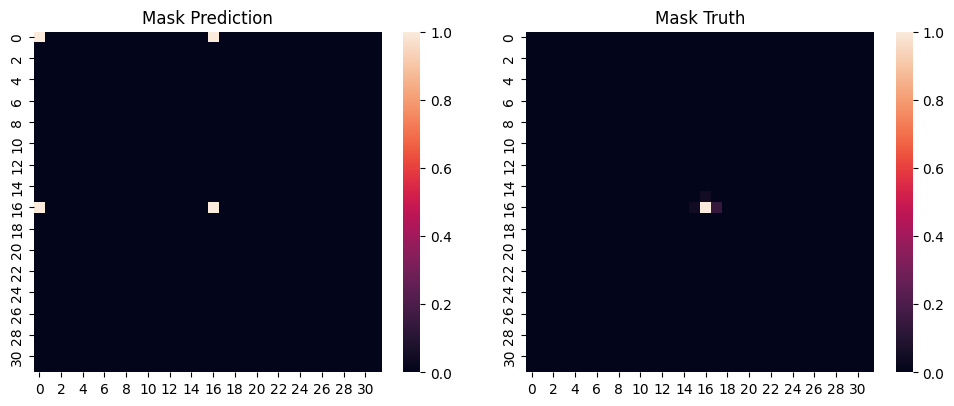

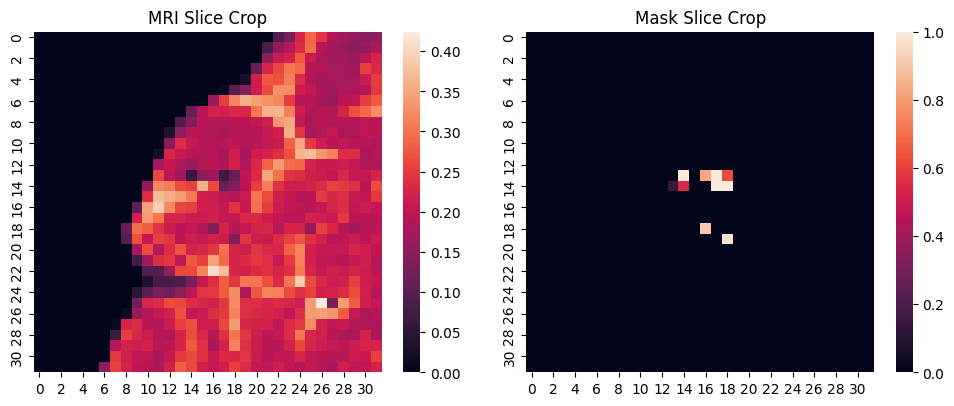

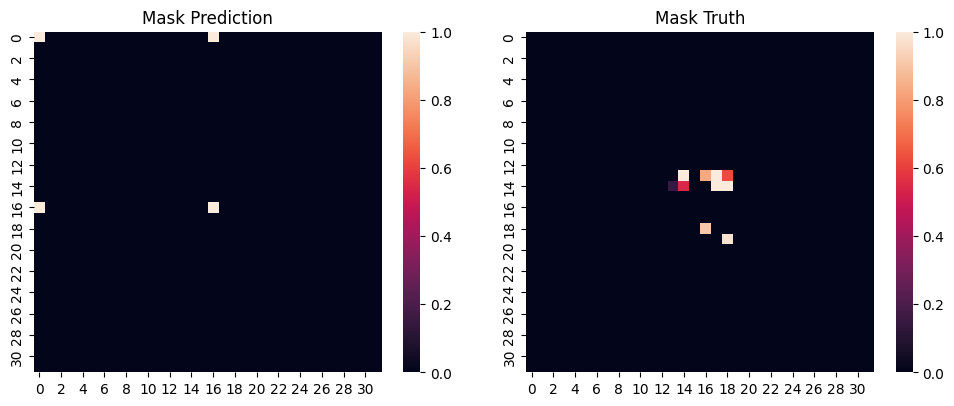

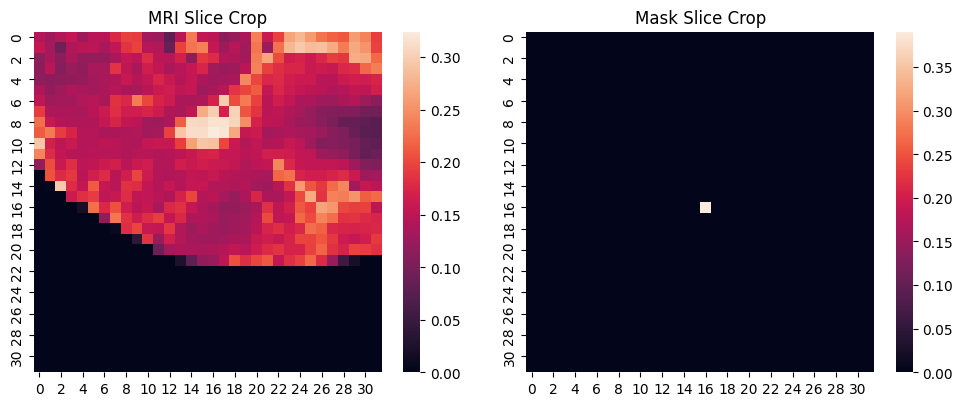

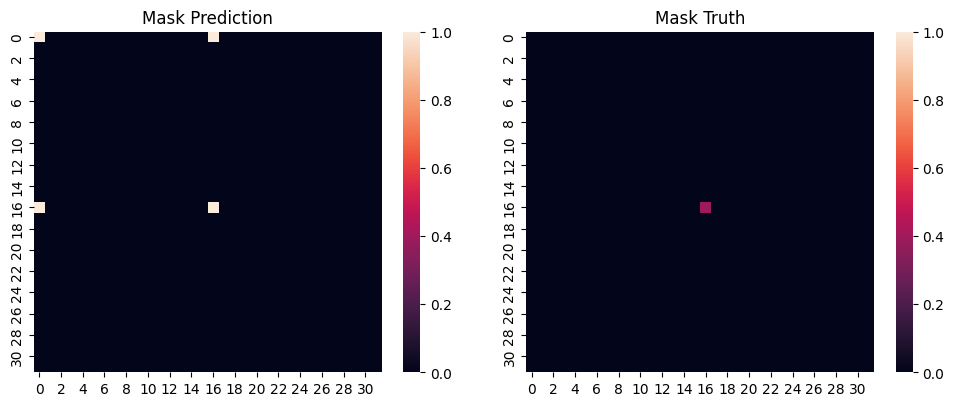

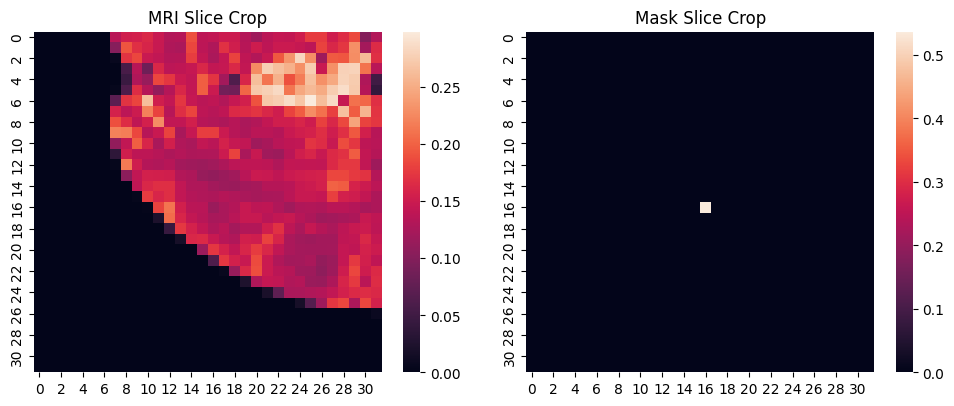

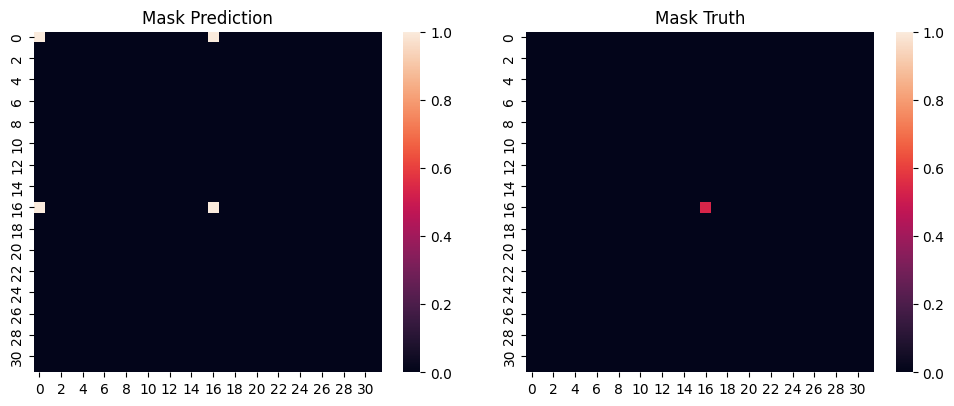

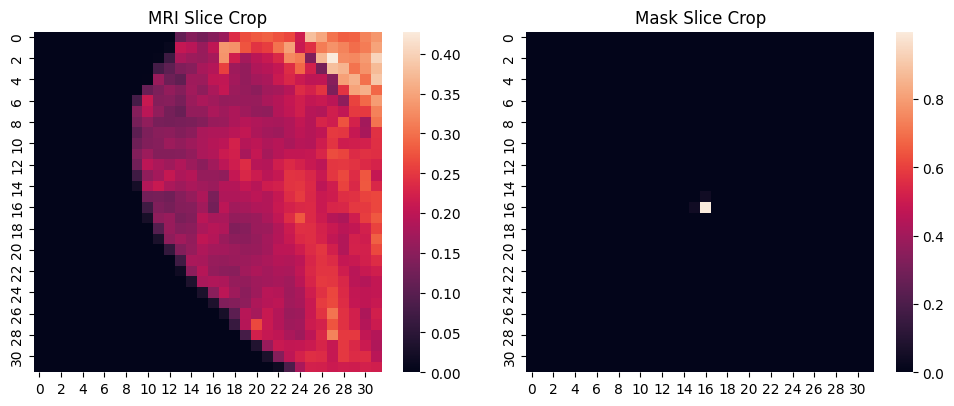

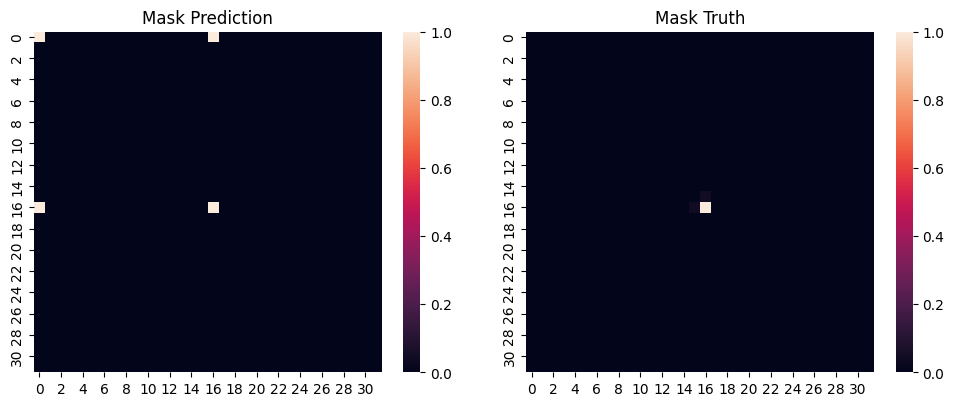

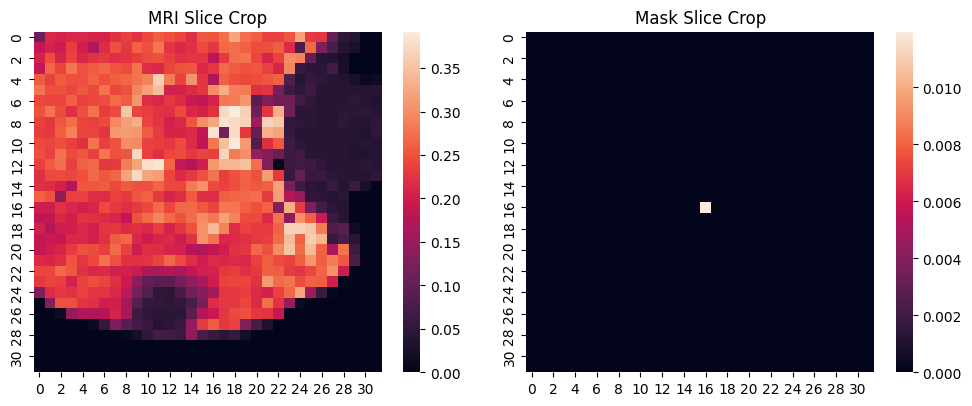

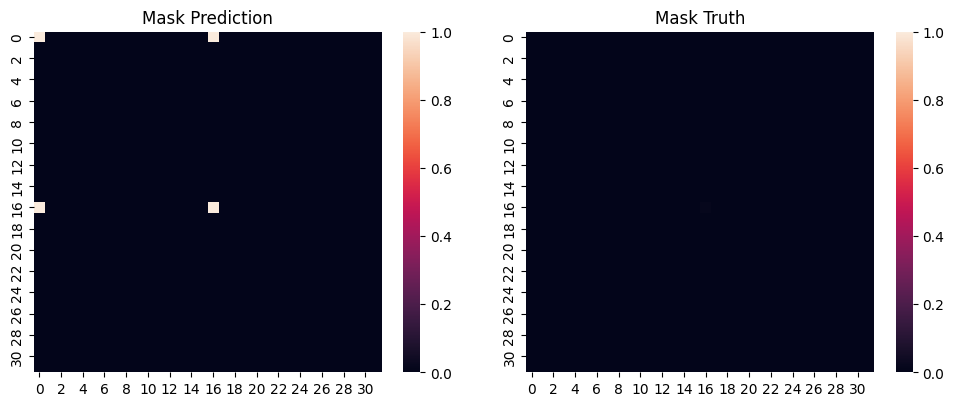

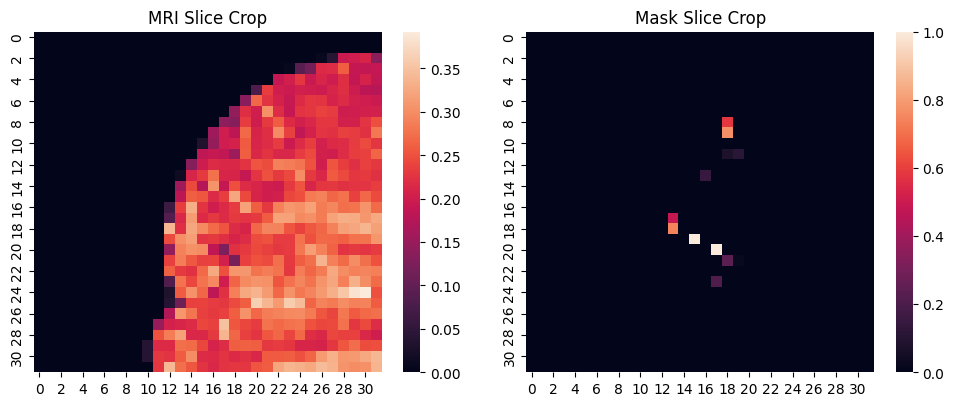

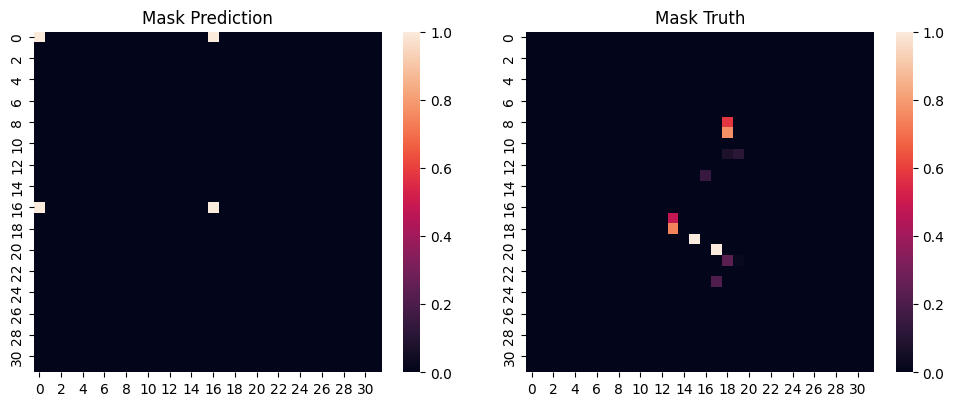

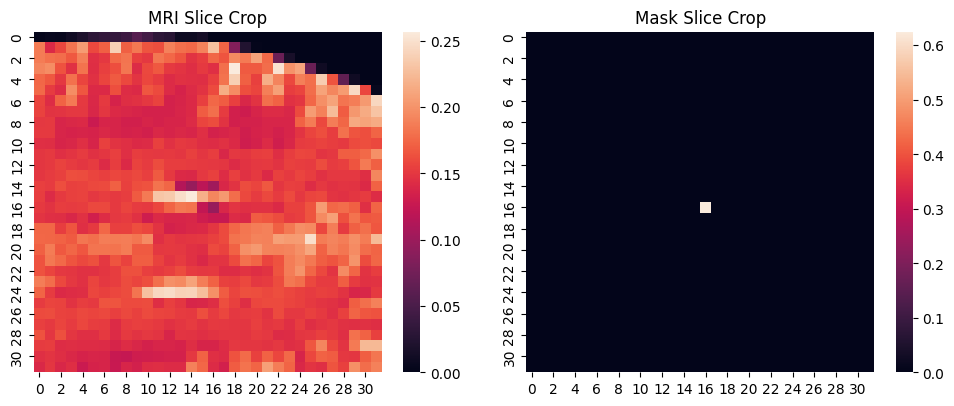

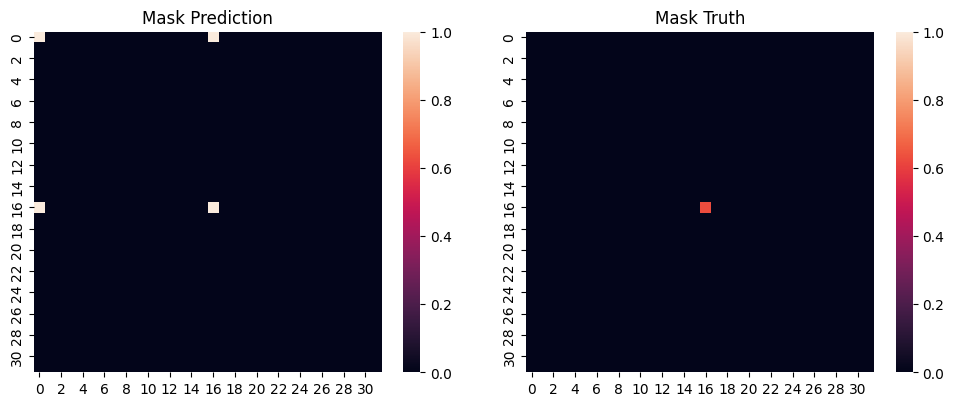

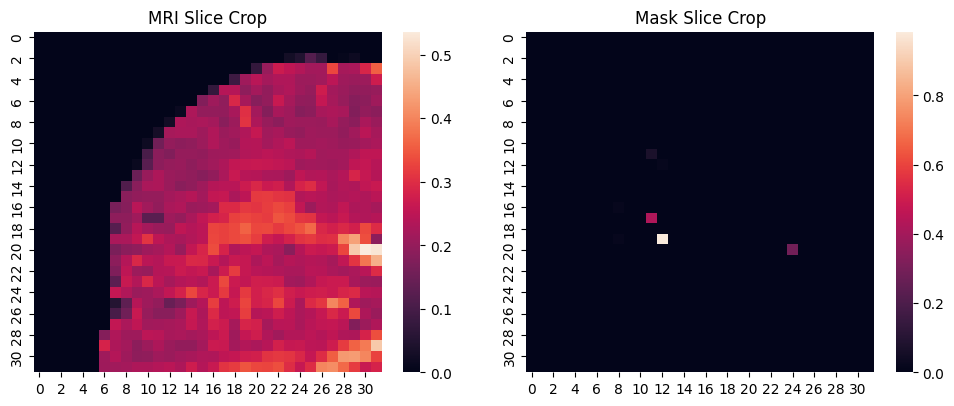

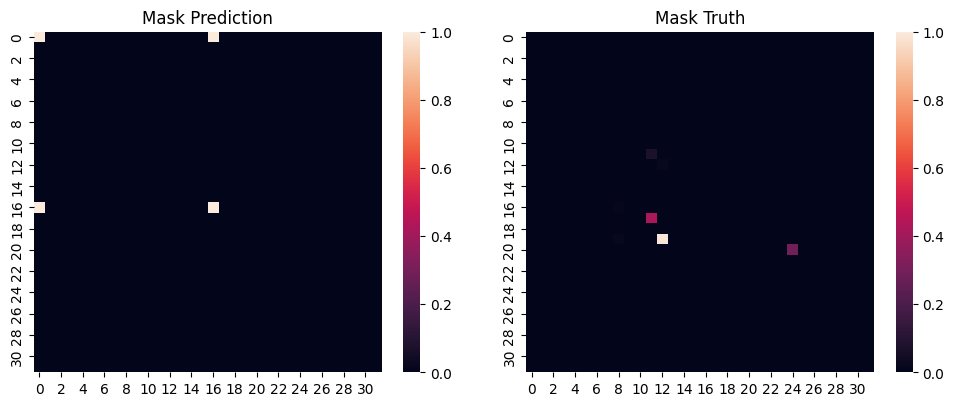

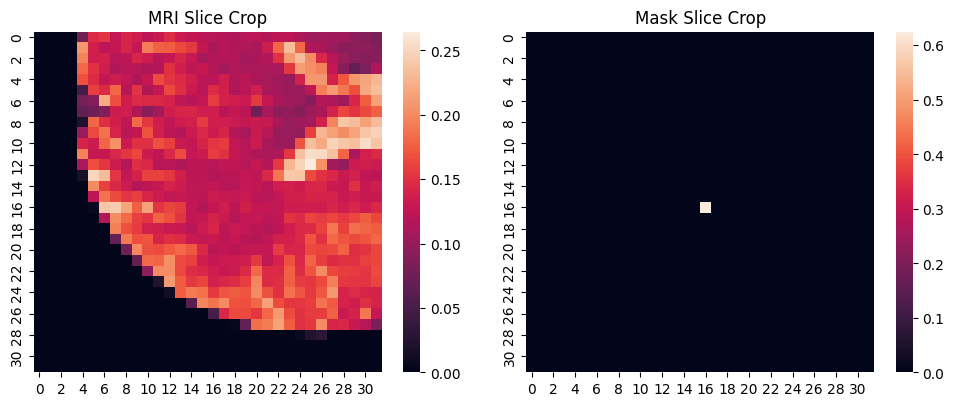

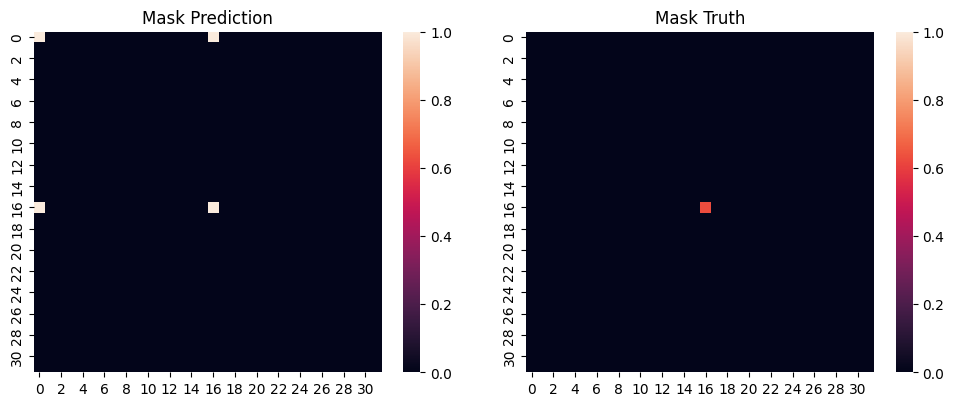

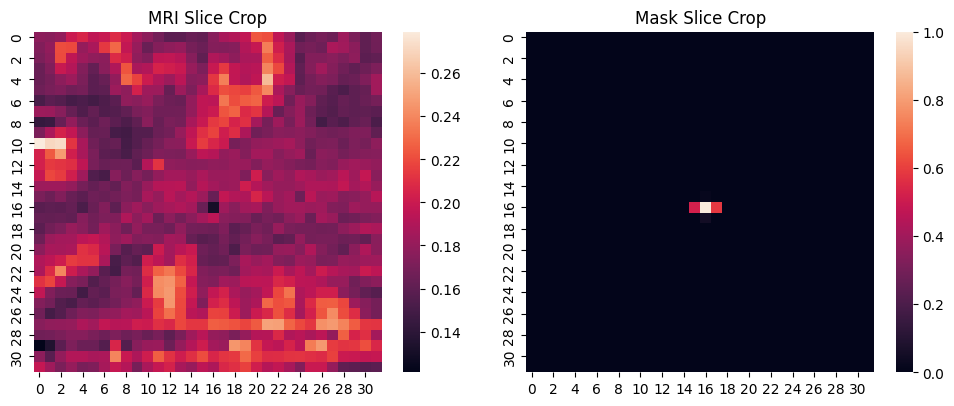

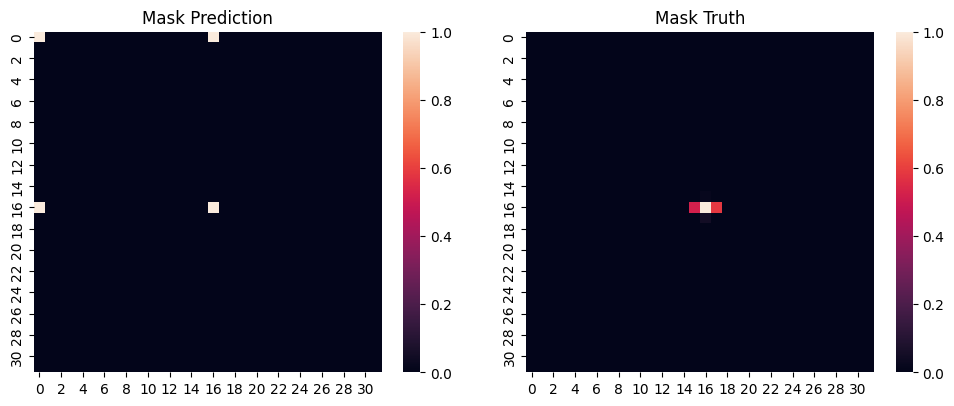

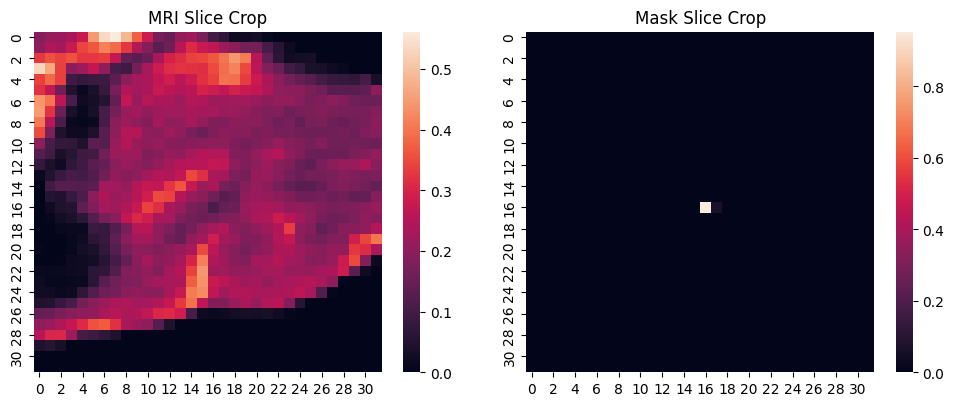

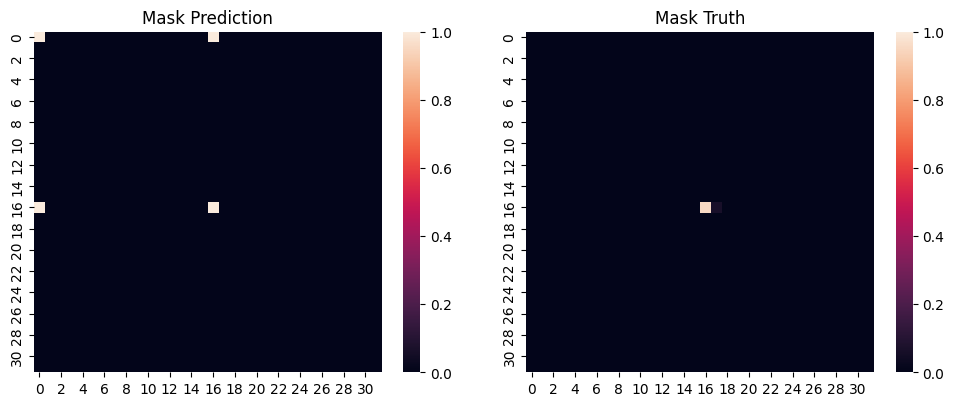

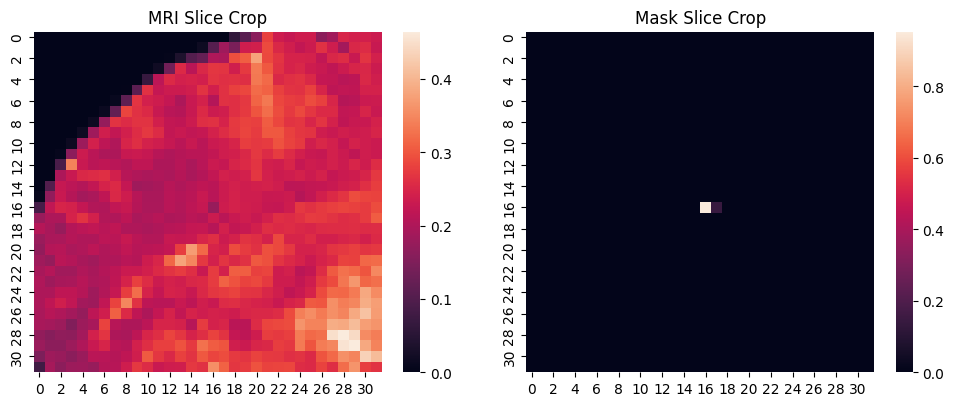

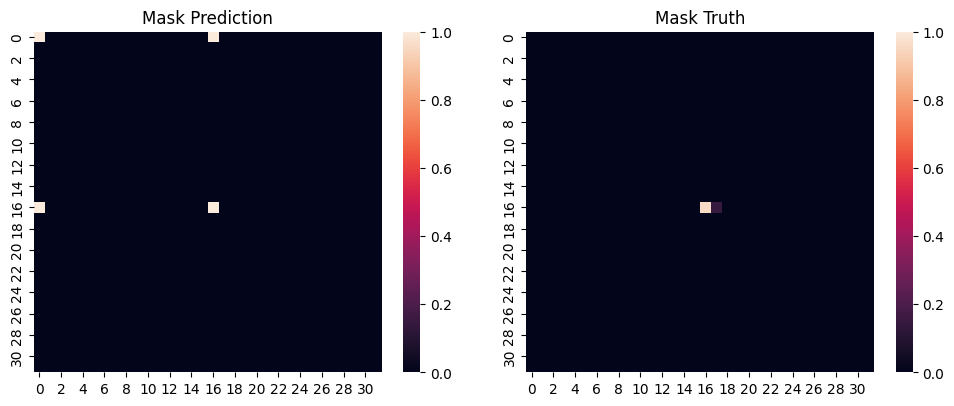

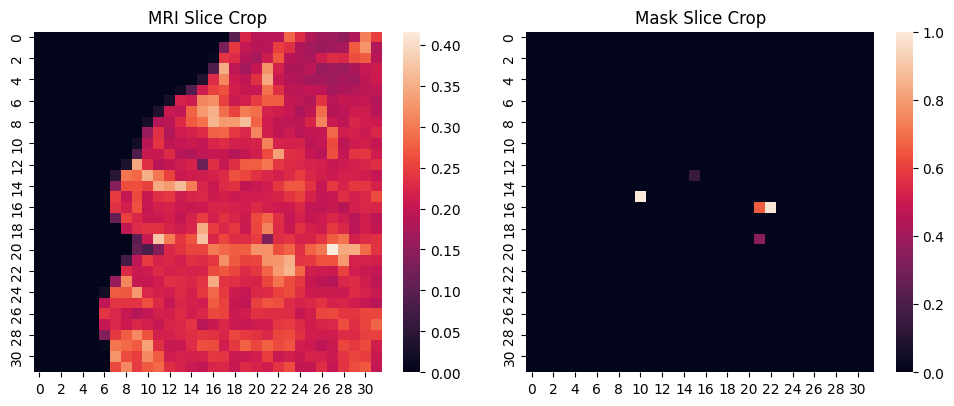

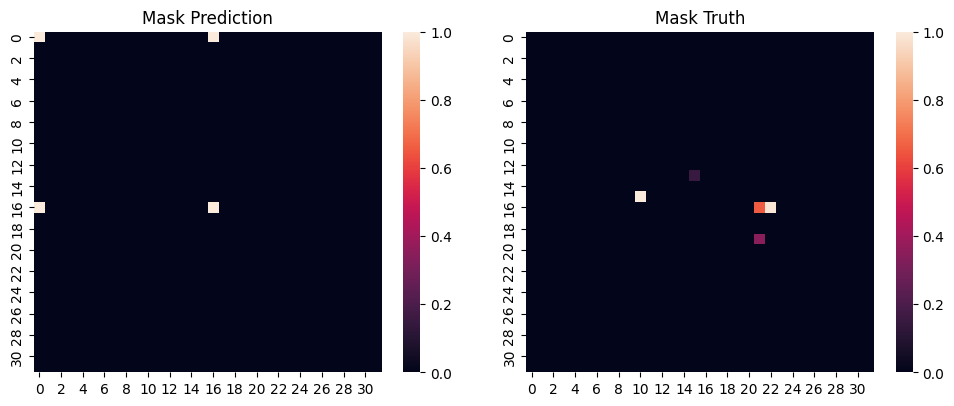

In [73]:
sample = next(iter(vit_test_dataloader))

for i in range(len(next(iter(vit_test_dataloader)))):
    vit_slices, vit_masks, vit_target, vit_case = sample[i]
    
    vit_slices = vit_slices.squeeze(1).float().to(device)
    vit_masks = vit_masks.float().to(device)
    
    regions = feedset.locate_case_by_mri(vit_case)
    bboxes = regions[1].view(regions[1].shape[0], -1)
    bbox = bboxes[vit_target].int().tolist()
                    
    vit_x = feeder(vit_slices, bbox, patch_size)
    vit_t = feeder(vit_masks, bbox, patch_size)
    
    f, a = plt.subplots(1, 2, figsize=(10, 4))

    f.tight_layout()
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('MRI Slice Crop')
    ax2.set_title('Mask Slice Crop')
    sns.heatmap(vit_x[vit_target].squeeze(), ax=ax1)
    sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2)

    vit_y = vit_fitter.model(vit_x.flatten(2).to(device), vit_target)
    vit_y = vit_y.view(patch_size, patch_size)
    vit_y = torch.sigmoid(vit_y)
    
    f, a = plt.subplots(1, 2, figsize=(10, 4))

    f.tight_layout()
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('Mask Prediction')
    ax2.set_title('Mask Truth')
    sns.heatmap((vit_y > 0.5).detach().cpu(), ax=ax1, vmax=1)
    sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2, vmax=1)

# Log Progress


In [74]:
vit_tk.notes = '''
no global context
'''

In [75]:
vit_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-12-09 08:27:32.320754,ViT,None,None,None,True,True,False,True,<class 'torch.optim.adam.Adam'>,50,...,0 0.653846 1 0.653846 2 0.653846 3 ...,0 0.333333 1 0.333333 2 0.333333 3 ...,0 3.105263 1 3.105263 2 3.105263 3 ...,None,None,None,"{'d_model': 512, 'patch_size': 32, 'dim_ff': 1...",rpn_vit_Dec_09_2024_082732.log,cuda,\nno global context\n


In [76]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, vit_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    vit_tk().to_csv('history/runs.csv')

Merging to old df


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_24396\3886131270.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([prev_df, vit_tk()])
